In [20]:
import logic.pulsed.pulse_objects as po
from logic.pulsed.sampling_functions import SamplingFunctions as SF
import time
import matplotlib.pyplot as plt
pml = pulsedmeasurementlogic
pmal = pulsedmasterlogic

In [21]:
Sync_time = (16e-9+476.5/1.25e9)
print("Sync",Sync_time)

Rearm_time = (40/1.25e9)
print("Rearm_time",Rearm_time)


Sync 3.972e-07
Rearm_time 3.2e-08


#### Define pulse block creation class

In [22]:
class qudi_pulse_block:

    def __init__(self, pi_pulse=1e-9, awg_sync_time=16e-9 + 476.5/1.25e9, laser_waiting_time=1.5e-6, mw_waiting_time=1e-6, read_out_time=3e-6,
                LO_freq=3e9, target_freq=2.88e9, power=-20):
        
        self.pi_pulse = pi_pulse
        self.awg_sync_time = awg_sync_time #Has to be determined with sample clock
        self.laser_waiting_time = laser_waiting_time
        self.mw_waiting_time = mw_waiting_time
        self.read_out_time = read_out_time
        self.laser_volt = podmrlogic.laser_power_voltage
        self.LO_freq = LO_freq
        self.target_freq = target_freq
        self.power = power
        print("Using laser voltage: ", self.laser_volt,"V")
        print("Using LO_freq: ", self.LO_freq/1e9,"GHz")
        print("Using target_freq: ", self.target_freq/1e9,"GHz")
        print("Using power: ", self.power,"dBm")
        
        self.channel_names_PS = {'Laser': 'd_ch1',
                                 'TT_Start': 'd_ch2',
                                 'TT_Next': 'd_ch3',
                                 'ASC500': 'd_ch4',
                                 'MW_Switch': 'd_ch5',
                                 'MW_Trig': 'd_ch6',                                
                                 'AWG_Trig': 'd_ch7',
                                 'AWG_Clock': 'd_ch8'
                                }
        
    def ElementPS(self, channels={}, length=1e-9, laser_power=None, phase=0):
        """PulseBlock element list maker for PulseStreamer upload. Also makes the phase duration list for the AWG.
        """
        a_ch = {'a_ch1': SF.DC(laser_power) if laser_power else SF.DC(self.laser_volt), 'a_ch2': SF.DC(0)}
        d_ch = { 'd_ch1': False, 'd_ch2': False, 'd_ch3': False, 'd_ch4': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        for key in channels:
            PSkey = self.channel_names_PS[key]
            if 'a_' in key:
                a_ch[PSkey] = channels[key]
            else:
                d_ch[PSkey] = channels[key]
        
        self.BlockPS.append(po.PulseBlockElement(init_length_s=length, pulse_function=a_ch, digital_high=d_ch))
        if isinstance(phase, tuple):
            self.PhaseDuration.append((phase[0],length/2))
            self.PhaseDuration.append((phase[1],length/2))
        else:
            self.PhaseDuration.append((phase,length))
        
    def AWG_reset(self):
        afm_scanner_logic._AWG.pulser_off()
        afm_scanner_logic._AWG.instance.init_all_channels()
        afm_scanner_logic._mw.off()
        
    def AWG_start(self):
        afm_scanner_logic._pulsed_master_AWG.pulsedmeasurementlogic().pulsegenerator().pulser_on(trigger=True)
        afm_scanner_logic._mw.set_cw(frequency=self.LO_freq, power=self.power)
        afm_scanner_logic._mw.cw_on()
        
    def sample_load_large_sine_AWG(self, name):
        #Create large pulse block for the AWG
        self.AWG_reset()
        delta = abs(self.LO_freq - self.target_freq)
        large_seq = []
        #skipping first element since it is the AWG sync time
        #skipping last element since AWG has a rearm time before the next averaging repetition trigger arrives
        for PhaseElement in self.PhaseDuration[1:-1]:
            phase, duration = PhaseElement
            seq_part = {'channel_info' : [   {'name': 'a_ch0', 'amp': 2.0, 'freq': delta, 'phase': 0.00+phase},
                         {'name': 'a_ch1', 'amp': 2.0, 'freq': delta, 'phase': 100.00+phase}],
                         'duration' : duration}
            large_seq.append(seq_part)
        
        load_large_sin_seq(large_seq=large_seq, identifier=name)
        self.AWG_start()
        
    def sample_load_short_sine_AWG(self, name):
        #Create large pulse block for the AWG
        self.AWG_reset()
        delta = abs(self.LO_freq - self.target_freq)
        large_seq = []
        duration = self.laser_waiting_time - self.awg_sync_time + self.pi_pulse + self.tau_arr[0]
        if duration<self.pi_pulse:
            print('Error: AWG play time is too small. Check self.laser_waiting_time and tau_start!')
            return
        seq_part = {'channel_info' : [   {'name': 'a_ch0', 'amp': 2.00, 'freq': delta, 'phase': 0.00},
                         {'name': 'a_ch1', 'amp': 2.00, 'freq': delta, 'phase': 100.00}],
                         'duration' : duration}
        large_seq.append(seq_part)
        
        load_large_sin_seq(large_seq=large_seq, identifier=name)
        self.AWG_start()
        
    def Rabi(self, tau_start, tau_stop, tau_num):
        '''
        '''        
        name = 'rabi-juptr'
        self.tau_arr = np.linspace(tau_start, tau_stop, num=tau_num)
        
        #Create pulse sequence for the pulse streamer
        self.BlockPS = []
        self.PhaseDuration = []

        #Trigger AWG to play its sequence, which includes one complete sweep of all waiting times        
        self.ElementPS(channels={'AWG_Trig':True}, length=self.awg_sync_time)
        
        for tau in self.tau_arr:
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time) 
            #Pi pulse - reference
            self.ElementPS(channels={'MW_Switch':True}, length=tau)
            #Waiting time - tau
            self.ElementPS(channels={'TT_Next':True}, length=self.mw_waiting_time)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)

        sample_load_ready_pulsed_measurement(name=name, 
                                             element_list=self.BlockPS, tau_arr=self.tau_arr, alternating=False)
        self.sample_load_large_sine_AWG(name)
    
    def T1_optical_exp(self, tau_start, tau_stop, tau_num):
        '''
        '''
        name = 't1-opti-exp-juptr'
        self.tau_arr = np.logspace(np.log10(tau_start), np.log10(tau_stop), num=tau_num)
        
        #Create pulse sequence for the pulse streamer
        self.BlockPS = []
        self.PhaseDuration = []
        
        for tau in self.tau_arr:
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time) 
            #Waiting time - tau
            self.ElementPS(channels={'TT_Next':True}, length=tau)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)

        sample_load_ready_pulsed_measurement(name=name, 
                                             element_list=self.BlockPS, tau_arr=self.tau_arr, alternating=False)
    
    def T1_alt_exp_long(self, tau_start, tau_stop, tau_num):
        '''
        '''        
        name = 't1-alt-exp-long-juptr'
        self.tau_arr = np.logspace(np.log10(tau_start), np.log10(tau_stop), num=tau_num)
        
        #Create pulse sequence for the pulse streamer
        self.BlockPS = []
        self.PhaseDuration = []

        #Trigger AWG to play its sequence, which includes one complete sweep of all waiting times        
        self.ElementPS(channels={'AWG_Trig':True}, length=self.awg_sync_time)
        
        for tau in self.tau_arr:
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time) 
            #Pi pulse - reference
            self.ElementPS(channels={}, length=self.pi_pulse)
            #Waiting time - tau
            self.ElementPS(channels={'TT_Next':True}, length=tau)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)
            
            #Alternating
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time)
            #Pi pulse - reference
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse)
            #Waiting time - tau
            self.ElementPS(channels={'TT_Next':True}, length=tau)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)

        sample_load_ready_pulsed_measurement(name=name, 
                                             element_list=self.BlockPS, tau_arr=self.tau_arr, alternating=True)
        self.sample_load_large_sine_AWG(name)
        
    def T1_alt_exp(self, tau_start, tau_stop, tau_num):
        '''
        '''        
        name = 't1-alt-exp-juptr'
        self.tau_arr = np.logspace(np.log10(tau_start), np.log10(tau_stop), num=tau_num)
        
        #Create pulse sequence for the pulse streamer
        self.BlockPS = []
        self.PhaseDuration = []
        
        for tau in self.tau_arr:
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time) 
            #Pi pulse - reference
            self.ElementPS(channels={}, length=self.pi_pulse)
            #Waiting time - tau
            self.ElementPS(channels={'TT_Next':True}, length=tau)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)
            
            #Alternating
            #Break after Initalisation/read out
            self.ElementPS(channels={'AWG_Trig':True}, length=self.laser_waiting_time)
            #Pi pulse - reference
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse)
            #Waiting time - tau
            self.ElementPS(channels={'TT_Next':True}, length=tau)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)

        sample_load_ready_pulsed_measurement(name=name, 
                                             element_list=self.BlockPS, tau_arr=self.tau_arr, alternating=True)
        self.sample_load_short_sine_AWG(name)
    
    def Ramsey_alt_phased(self, tau_start, tau_stop, tau_num):
        '''
        '''
        name = 'ramsey-alt-phased-juptr'
        self.tau_arr = np.linspace(tau_start, tau_stop, num=tau_num)
        
        #Create pulse sequence for the pulse streamer
        self.BlockPS = []
        self.PhaseDuration = []

        #Trigger AWG to play its sequence, which includes one complete sweep of all waiting times        
        self.ElementPS(channels={'AWG_Trig':True}, length=self.awg_sync_time)
        
        for tau in self.tau_arr:
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time)
            #Pi/2 pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2)
            #First waiting time - tau
            self.ElementPS(channels={}, length=tau)
            #Pi/2 pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2)
            #Waiting time
            self.ElementPS(channels={'TT_Next':True}, length=self.mw_waiting_time)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)
            
            #Alternating run
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time)
            #Pi/2 pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2)
            #Second waiting time + tau
            self.ElementPS(channels={}, length=tau, phase=(0,180))
            #Pi/2 pulse Phase change cause -pi/2 pulse - done by AWG
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2, phase=180)
            #Waiting time
            self.ElementPS(channels={'TT_Next':True}, length=self.mw_waiting_time, phase=180)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time, phase=180)
        
        sample_load_ready_pulsed_measurement(name=name, 
                                             element_list=self.BlockPS, tau_arr=self.tau_arr, alternating=True)
        self.sample_load_large_sine_AWG(name)
    
    def Hecho_alt_phased(self, tau_start, tau_stop, tau_num):
        '''
        '''
        name = 'hecho-alt-phased-juptr'
        self.tau_arr = np.linspace(tau_start, tau_stop, num=tau_num)
        
        #Create pulse sequence for the pulse streamer
        self.BlockPS = []
        self.PhaseDuration = []

        #Trigger AWG to play its sequence, which includes one complete sweep of all waiting times        
        self.ElementPS(channels={'AWG_Trig':True}, length=self.awg_sync_time)
        
        for tau in self.tau_arr:
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time)
            #Pi/2 pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2)
            #First waiting time + tau/2
            self.ElementPS(channels={}, length=tau/2)
            #Pi pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse)
            #Second waiting time + tau/2
            self.ElementPS(channels={}, length=tau/2)
            #Pi/2 pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2)
            #Waiting time
            self.ElementPS(channels={'TT_Next':True}, length=self.mw_waiting_time)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time)
            
            #Alternating run
            #Break after Initalisation/read out
            self.ElementPS(channels={}, length=self.laser_waiting_time)
            #Pi/2 pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2)
            #First waiting time + tau/2
            self.ElementPS(channels={}, length=tau/2)
            #Pi pulse
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse)
            #Second waiting time + tau/2
            self.ElementPS(channels={}, length=tau/2, phase=(0,180))
            #Pi/2 pulse Phase change cause -pi/2 pulse - done by AWG
            self.ElementPS(channels={'MW_Switch':True}, length=self.pi_pulse/2, phase=180)
            #Waiting time
            self.ElementPS(channels={'TT_Next':True}, length=self.mw_waiting_time, phase=180)
            #Read out
            self.ElementPS(channels={'Laser':True, 'TT_Start':True}, length=self.read_out_time, phase=180)
        
        sample_load_ready_pulsed_measurement(name=name, 
                                             element_list=self.BlockPS, tau_arr=self.tau_arr, alternating=True)
        self.sample_load_large_sine_AWG(name)

Helpers

In [23]:
def load_sin(channels = [{'name': 'a_ch0', 'amp': 1.00}], dur=1e-6, identifier=''):
        """
        Load a sine waveform to be played simultaneously on the specified channels.
        """
        ele = []
        a_ch = {'a_ch0': SF.DC(0), 'a_ch1': SF.DC(0), 'a_ch2': SF.DC(0), 'a_ch3': SF.DC(0)}
        d_ch = {'d_ch0': False, 'd_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False}
        for ch in channels:
            a_ch[ch['name']] = SF.Sin(amplitude=ch['amp'], frequency=ch['freq'], phase=ch['phase'])
            
        ele.append(po.PulseBlockElement(init_length_s=dur,  pulse_function=a_ch, digital_high=d_ch))
        pulse_block = po.PulseBlock(name=f'SinJupyterHecho-031123-block{identifier}', element_list=ele)
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().save_block(pulse_block)

        block_list = []
        block_list.append((pulse_block.name, 0))
        auto_pulse_CW = po.PulseBlockEnsemble(f'SinJupyterHecho-031123{identifier}', block_list)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().save_ensemble(ensemble)
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().sample_pulse_block_ensemble(ensemblename)
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().load_ensemble(ensemblename)

def load_large_sin_seq(large_seq = [{'name': 'a_ch0', 'amp': 1.00}], identifier=''):
        """
        Load a large sequence to be played on the AWG.
        """
        
        ele = []
        
        for step in large_seq:
            channels = step['channel_info']
            dur = step['duration']
        
            a_ch = {'a_ch0': SF.DC(0), 'a_ch1': SF.DC(0), 'a_ch2': SF.DC(0), 'a_ch3': SF.DC(0)}
            d_ch = {'d_ch0': True, 'd_ch1': False, 'd_ch2': True, 'd_ch4': True, 'd_ch3': True, 'd_ch5': True}
            for ch in channels:
                a_ch[ch['name']] = SF.Sin(amplitude=ch['amp'], frequency=ch['freq'], phase=ch['phase'])

            ele.append(po.PulseBlockElement(init_length_s=dur,  pulse_function=a_ch, digital_high=d_ch))
        pulse_block = po.PulseBlock(name=f'Jupyter-block-{identifier}', element_list=ele)
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().save_block(pulse_block)

        block_list = []
        block_list.append((pulse_block.name, 0))
        auto_pulse_CW = po.PulseBlockEnsemble(f'Jupyter-ensemble-{identifier}', block_list)

        ensemble = auto_pulse_CW
        ensemblename = auto_pulse_CW.name
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().save_ensemble(ensemble)
        afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().sample_pulse_block_ensemble(ensemblename)
#         afm_scanner_logic._pulsed_master_AWG.sequencegeneratorlogic().load_ensemble(ensemblename)
        afm_scanner_logic._AWG.load_triggered_multi_replay([ensemblename])
        
def sample_load_ready_pulsed_measurement(name = 'pulse_measurement', element_list = [], tau_arr = [], alternating = False):
    
    pulse_block = po.PulseBlock(name=name, element_list=element_list)
    sequencegeneratorlogic.save_block(pulse_block)
    
    block_list = []
    block_list.append((pulse_block.name, 0))
    pulse_block_ensemble = po.PulseBlockEnsemble(name, block_list)
    
    sequencegeneratorlogic.save_ensemble(pulse_block_ensemble)
    sequencegeneratorlogic.sample_pulse_block_ensemble(name)
    sequencegeneratorlogic.load_ensemble(name)
    
    tau_num = len(tau_arr) * 2 if alternating else len(tau_arr)
    pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                           controlled_variable=tau_arr,
                                           number_of_lasers=tau_num, 
                                           laser_ignore_list=[], 
                                           alternating=alternating, 
                                           units=('s', 'arb. u.'))
    pulsedmeasurementlogic.alternative_data_type = 'None'
    time.sleep(0.5)
    pulsedmasterlogic.set_fast_counter_settings(record_length=3e-6, number_of_gates=tau_num)
    time.sleep(0.5)
    for setting, value in pulsedmasterlogic.measurement_settings.items():
        print('{0}:\n  {1}'.format(setting, value))
        
def creat_save_tag(measurement_type = 'test', tip_name = '', temperature = '', m_field = '', contact = '', extra = ''):
    save_tag = measurement_type

    if tip_name:
        save_tag += '_'+tip_name
    if temperature:
        save_tag += '_'+temperature
    if m_field:
        save_tag += '_'+m_field
    if contact:
        save_tag += '_'+contact
    if extra:
        save_tag += '_'+extra
        
    pulsedmeasurement._mw.save_tag_LineEdit.setText(save_tag)
    print('Save_tag: ',save_tag)

    
    

#### Define general measurement params

In [27]:
#measurement parameters
pi_pulse = 57e-9 #if available 
LO_freq = 2.81e9
target_freq = 2.78469e9
power = -1

#additional information for save tag
tip_name = 'A-T17-12'
temperature = '10K'
m_field = '0mT_Bnv'
contact = 'OOC'
extra = ''

#### Load and ready Rabi sequence

In [26]:
tau_start = 0
tau_stop = 200e-9
tau_num = 50

PB = qudi_pulse_block(pi_pulse=pi_pulse, LO_freq=LO_freq, target_freq=target_freq, power=power)
PB.Rabi(tau_start, tau_stop, tau_num)
creat_save_tag(measurement_type = 'Rabi', tip_name = tip_name, temperature = temperature, m_field = m_field, contact = contact, extra = extra)

Using laser voltage:  0.07 V
Using LO_freq:  2.81 GHz
Using target_freq:  2.78469 GHz
Using power:  -1 dBm
invoke_settings:
  False
controlled_variable:
  [0.00000000e+00 4.08163265e-09 8.16326531e-09 1.22448980e-08
 1.63265306e-08 2.04081633e-08 2.44897959e-08 2.85714286e-08
 3.26530612e-08 3.67346939e-08 4.08163265e-08 4.48979592e-08
 4.89795918e-08 5.30612245e-08 5.71428571e-08 6.12244898e-08
 6.53061224e-08 6.93877551e-08 7.34693878e-08 7.75510204e-08
 8.16326531e-08 8.57142857e-08 8.97959184e-08 9.38775510e-08
 9.79591837e-08 1.02040816e-07 1.06122449e-07 1.10204082e-07
 1.14285714e-07 1.18367347e-07 1.22448980e-07 1.26530612e-07
 1.30612245e-07 1.34693878e-07 1.38775510e-07 1.42857143e-07
 1.46938776e-07 1.51020408e-07 1.55102041e-07 1.59183673e-07
 1.63265306e-07 1.67346939e-07 1.71428571e-07 1.75510204e-07
 1.79591837e-07 1.83673469e-07 1.87755102e-07 1.91836735e-07
 1.95918367e-07 2.00000000e-07]
number_of_lasers:
  50
laser_ignore_list:
  []
alternating:
  False
units:
  ('s'

#### Load and ready optical T1 sequence

In [2]:
tau_start = 1e-6
tau_stop = 1e-3
tau_num = 20

PB = qudi_pulse_block(pi_pulse=pi_pulse, LO_freq=LO_freq, target_freq=target_freq, power=power)
PB.T1_optical_exp(tau_start, tau_stop, tau_num)
creat_save_tag(measurement_type = 'T1-opt', tip_name = tip_name, temperature = temperature, m_field = m_field, contact = contact, extra = extra)

#### Load and ready T1 sequence (alternating)

In [28]:
tau_start = 1e-6
tau_stop = 50e-3
tau_num = 20

PB = qudi_pulse_block(pi_pulse=pi_pulse, LO_freq=LO_freq, target_freq=target_freq, power=power)
PB.T1_alt_exp(tau_start, tau_stop, tau_num)
creat_save_tag(measurement_type = 'T1-alt', tip_name = tip_name, temperature = temperature, m_field = m_field, contact = contact, extra = extra)

Using laser voltage:  0.07 V
Using LO_freq:  2.81 GHz
Using target_freq:  2.78469 GHz
Using power:  -1 dBm
invoke_settings:
  False
controlled_variable:
  [1.00000000e-06 1.76731601e-06 3.12340587e-06 5.52004518e-06
 9.75566420e-06 1.72413415e-05 3.04708988e-05 5.38517071e-05
 9.51729840e-05 1.68200738e-04 2.97263856e-04 5.25359171e-04
 9.28475673e-04 1.64090992e-03 2.90000636e-03 5.12522766e-03
 9.05789688e-03 1.60081661e-02 2.82914882e-02 5.00000000e-02]
number_of_lasers:
  40
laser_ignore_list:
  []
alternating:
  True
units:
  ('s', 'arb. u.')
labels:
  ['Tau', 'Signal']
Save_tag:  T1-alt_A-T17-12_10K_0mT_Bnv_OOC


#### Load and ready Ramsey sequence with phase shift (alternating)

In [11]:
tau_start = 10e-9
tau_stop = 5000e-9
tau_num = 50

PB = qudi_pulse_block(pi_pulse=pi_pulse, LO_freq=LO_freq, target_freq=target_freq, power=power)
PB.Ramsey_alt_phased(tau_start, tau_stop, tau_num)
creat_save_tag(measurement_type = 'Ramsey-alt-phased', tip_name = tip_name, temperature = temperature, m_field = m_field, contact = contact, extra = extra)

Using laser voltage:  0.08 V
Using LO_freq:  2.87 GHz
Using target_freq:  2.85511 GHz
Using power:  -1 dBm
invoke_settings:
  False
controlled_variable:
  [1.00000000e-08 1.11836735e-07 2.13673469e-07 3.15510204e-07
 4.17346939e-07 5.19183673e-07 6.21020408e-07 7.22857143e-07
 8.24693878e-07 9.26530612e-07 1.02836735e-06 1.13020408e-06
 1.23204082e-06 1.33387755e-06 1.43571429e-06 1.53755102e-06
 1.63938776e-06 1.74122449e-06 1.84306122e-06 1.94489796e-06
 2.04673469e-06 2.14857143e-06 2.25040816e-06 2.35224490e-06
 2.45408163e-06 2.55591837e-06 2.65775510e-06 2.75959184e-06
 2.86142857e-06 2.96326531e-06 3.06510204e-06 3.16693878e-06
 3.26877551e-06 3.37061224e-06 3.47244898e-06 3.57428571e-06
 3.67612245e-06 3.77795918e-06 3.87979592e-06 3.98163265e-06
 4.08346939e-06 4.18530612e-06 4.28714286e-06 4.38897959e-06
 4.49081633e-06 4.59265306e-06 4.69448980e-06 4.79632653e-06
 4.89816327e-06 5.00000000e-06]
number_of_lasers:
  100
laser_ignore_list:
  []
alternating:
  True
units:
  ('s'

#### Load and ready Hahn Echo sequence with phase shift (alternating)

In [7]:
tau_start = 100e-9
tau_stop = 15000e-9
tau_num = 50

PB = qudi_pulse_block(pi_pulse=pi_pulse, LO_freq=LO_freq, target_freq=target_freq, power=power)
PB.Hecho_alt_phased(tau_start, tau_stop, tau_num)
creat_save_tag(measurement_type = 'Hecho-alt-phased', tip_name = tip_name, temperature = temperature, m_field = m_field, contact = contact, extra = extra)

Using laser voltage:  0.08 V
Using LO_freq:  2.87 GHz
Using target_freq:  2.85511 GHz
Using power:  -1 dBm
invoke_settings:
  False
controlled_variable:
  [1.00000000e-07 4.04081633e-07 7.08163265e-07 1.01224490e-06
 1.31632653e-06 1.62040816e-06 1.92448980e-06 2.22857143e-06
 2.53265306e-06 2.83673469e-06 3.14081633e-06 3.44489796e-06
 3.74897959e-06 4.05306122e-06 4.35714286e-06 4.66122449e-06
 4.96530612e-06 5.26938776e-06 5.57346939e-06 5.87755102e-06
 6.18163265e-06 6.48571429e-06 6.78979592e-06 7.09387755e-06
 7.39795918e-06 7.70204082e-06 8.00612245e-06 8.31020408e-06
 8.61428571e-06 8.91836735e-06 9.22244898e-06 9.52653061e-06
 9.83061224e-06 1.01346939e-05 1.04387755e-05 1.07428571e-05
 1.10469388e-05 1.13510204e-05 1.16551020e-05 1.19591837e-05
 1.22632653e-05 1.25673469e-05 1.28714286e-05 1.31755102e-05
 1.34795918e-05 1.37836735e-05 1.40877551e-05 1.43918367e-05
 1.46959184e-05 1.50000000e-05]
number_of_lasers:
  100
laser_ignore_list:
  []
alternating:
  True
units:
  ('s'

Tests

In [ ]:
def load_waveform(self, load_dict):
        """ Loads a waveform from the waveform folder on disk to all specified channels of the pulsing device.

        The file on disk has to have the corresponding channel name in the file name. eg.
            hahn_echo_a_ch0.pkl
            hahn_echo_d_ch1.pkl
        will be loaded into analog ch0 and digital ch1 respectively.


        @param dict|list load_dict: a dictionary with keys being one of the available channel
                                    index and values being the name of the already written
                                    waveform to load into the channel.
                                    Examples:   {1: rabi_ch1, 2: rabi_ch2} or
                                                {1: rabi_ch2, 2: rabi_ch1}
                                    If just a list of waveform names if given, the channel
                                    association will be invoked from the channel
                                    suffix '_ch1', '_ch2' etc.

                                        {1: rabi_ch1, 2: rabi_ch2}
                                    or
                                        {1: rabi_ch2, 2: rabi_ch1}

                                    If just a list of waveform names if given,
                                    the channel association will be invoked from
                                    the channel suffix '_ch1', '_ch2' etc. A
                                    possible configuration can be e.g.

                                        ['rabi_ch1', 'rabi_ch2', 'rabi_ch3']

        @return dict: Dictionary containing the actually loaded waveforms per
                      channel.

        For devices that have a workspace (i.e. AWG) this will load the waveform
        from the device workspace into the channel. For a device without mass
        memory, this will make the waveform/pattern that has been previously
        written with self.write_waveform ready to play.

        Please note that the channel index used here is not to be confused with the number suffix
        in the generic channel descriptors (i.e. 'd_ch1', 'a_ch1'). The channel index used here is
        highly hardware specific and corresponds to a collection of digital and analog channels
        being associated to a SINGLE waveform asset.
        """

        # create new dictionary with keys = num_of_ch and item = waveform

        max_chunk_size = self.instance.max_chunk_size
        empty_chunk_array_factor = self.instance.empty_chunk_array_factor

        if isinstance(load_dict, list):
            new_dict = dict()
            for waveform in load_dict:
                wave_name = waveform.rsplit('.pkl')[0]
                channel_num = int(wave_name.rsplit('_ch', 1)[1])
                # Map channel numbers to HW channel numbers
                if '_a_ch' not in waveform:
                    channel = channel_num + 4
                else:
                    channel = channel_num
                new_dict[channel] = wave_name
            load_dict = new_dict

        if not load_dict:
            self.log.error('No data to send to AWG')
            return -1

        # Get a list of  all pkl waveforms in waveform folder
        path = self.waveform_folder
        wave_form_list = self.get_waveform_names()

        data_list = list()
        data_sizes = list()
        # this looks like 4 analog channels and 6 digital
        # for i in range(4):
        #     data_list.append(np.zeros(int(max_chunk_size * empty_chunk_array_factor), np.int16))
        # for i in range(6):
        #     data_list.append(np.zeros(int(max_chunk_size * empty_chunk_array_factor), np.bool))

        for ch, value in load_dict.items():
            if value in wave_form_list:
                wavefile = '{0}.pkl'.format(value)
                filepath = os.path.join(path, wavefile)
                data = self.my_load_dict(filepath)
                # data_list[ch][0:len(data)] = data
                data_list.append(data.astype(np.float32))
                data_sizes.append(len(data))
                if '_a_ch' in value:
                    chan_name = 'a_ch{0}'.format(value.rsplit('a_ch')[1])
                    self.loaded_assets[chan_name] = value[:-6]
                else:
                    chan_name = 'd_ch{0}'.format(value.rsplit('d_ch')[1])
                    self.loaded_assets[chan_name] = value[:-6]
            else:
                self.log.warn('Waveform {} not found in {}'.format(value, self.waveform_folder))
                data_size = 0

        # If data sizes don't match the first file, append empty rows
        data_sizes = np.asarray(data_sizes)
        max_size = np.max(data_sizes)
        new_list = list()
        if np.std(data_sizes)!=0:
            for row in data_list:
                new_row = np.zeros(max_size, np.float32)
                new_row[0:len(row)] = row
                new_list.append(new_row)
            data_list = new_list

        # See pg 80 in manual
        count = 0
        while not max_size % 32 == 0:
            max_size += 1
            count += 1
        if not count == 1:
            extra = np.zeros(count, np.float32)
            new_list = list()
            for row in data_list:
                new_row = np.concatenate((row, extra), axis=0)
                new_list.append(new_row)
            data_list = new_list
        self.instance.set_memory_size(int(max_size))

        # Runs a threaded method to upload to both cards simultaneously
        # data_list is a list of analog and digital values
        # data_list[0, 1, 4, 5, 6] goes to card 0
        # data_list[2, 3, 7, 8, 9] goes to card 1
        if not max_size == 0:
            self.instance.upload(data_list, max_size, mem_offset=0)
            self.typeloaded = 'waveform'
            # print(data_list[0][0:5])
        self.log.info('Loaded waveform!')
        return load_dict

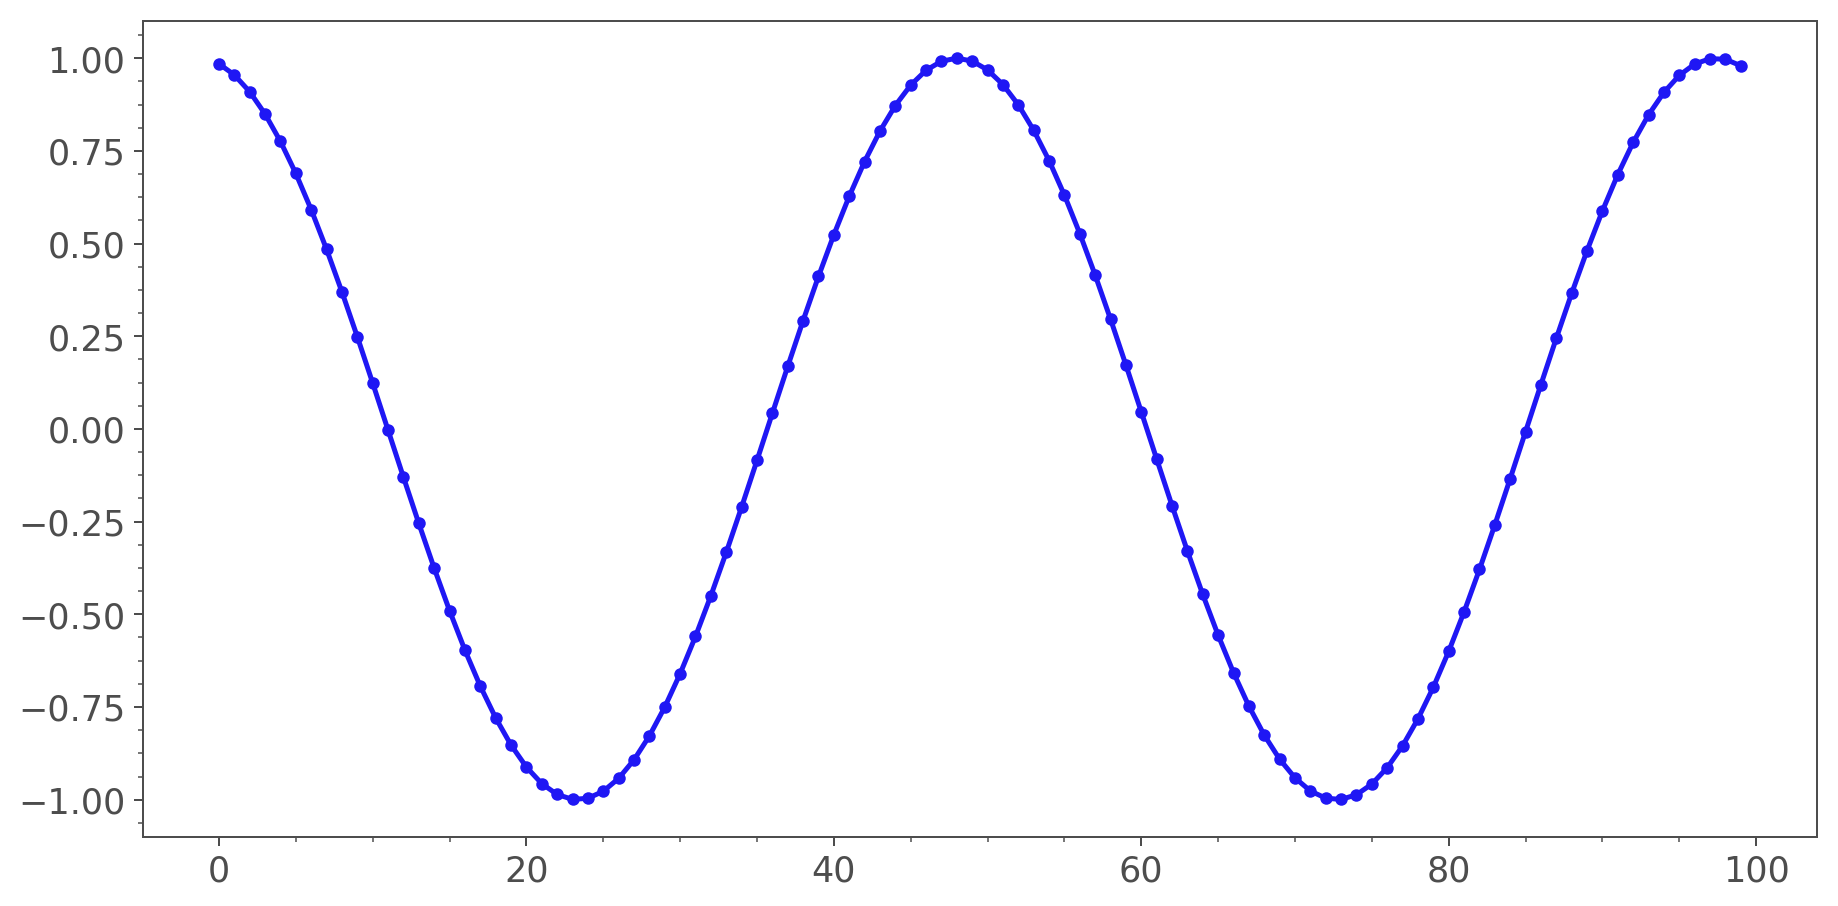

In [56]:
import matplotlib.pyplot as plt
plt.plot(awg_spectrum.debug_analog_samples['a_ch1'][0:100])#/(awg_spectrum.instance.cards[0].get_amplitude(1)/1e3) * (2 ** 15 - 1))
plt.show()

In [55]:
awg_spectrum.instance.cards[1].get_amplitude(0)

2000